In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import CausalInference
from pgmpy.models import BayesianNetwork

%load_ext lab_black

# Alarm*
From [Unit 3 - alarm.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit3/alarm.odc). This file doesn't run with WinBUGS, so make sure you use OpenBUGS if you want to try it out.

Associated lecture videos: Unit 3 Lessons 7 and 8.

When I first did these examples in Pgmpy, they were really difficult or impossible to do in PyMC3. I've heard they're now possible in PyMC, so at some point I'll circle back and redo them.

-------------------------

Your house has an alarm system against burglary. The house is located in the seismically active area and the alarm system can get occasionally set off by an earthquake. You have two neighbors, Mary and John, who do not know each other. If they hear the alarm they call you, but this is not guaranteed. They also call you from time to time just to chat. The professor has an approximate solution using BUGS available available above.

1. Find the probability John calls given an earthquake.

2. Find the probability that there was an earthquake given John has called.

3. Find the probability of an earthquake given John has not called and Mary has called.

Practice: Find the probability that there was a burglary given an alarm has gone off and Mary has not called.

Here's a pgmpy solution based on the nearly identical example at https://pgmpy.org/examples/Earthquake.html.

In [2]:
# Defining network structure
alarm_model = BayesianNetwork(
    [
        ("Burglary", "Alarm"),
        ("Earthquake", "Alarm"),
        ("Alarm", "JohnCalls"),
        ("Alarm", "MaryCalls"),
    ]
)

# Defining the parameters
cpd_burglary = TabularCPD(
    variable="Burglary", variable_card=2, values=[[0.999], [0.001]]
)

cpd_earthquake = TabularCPD(
    variable="Earthquake", variable_card=2, values=[[0.998], [0.002]]
)

cpd_alarm = TabularCPD(
    variable="Alarm",
    variable_card=2,
    values=[[0.999, 0.71, 0.06, 0.05], [0.001, 0.29, 0.94, 0.95]],
    evidence=["Burglary", "Earthquake"],
    evidence_card=[2, 2],
)

cpd_marycalls = TabularCPD(
    variable="MaryCalls",
    variable_card=2,
    values=[[0.99, 0.30], [0.01, 0.70]],
    evidence=["Alarm"],
    evidence_card=[2],
)

cpd_johncalls = TabularCPD(
    variable="JohnCalls",
    variable_card=2,
    values=[[0.95, 0.1], [0.05, 0.9]],
    evidence=["Alarm"],
    evidence_card=[2],
)

# Associating the parameters with the model structure
alarm_model.add_cpds(
    cpd_burglary, cpd_earthquake, cpd_alarm, cpd_johncalls, cpd_marycalls
)

alarm_model.check_model()

print(f"Nodes: {alarm_model.nodes()}")
print(f"Edges: {alarm_model.edges()}")

Nodes: ['Burglary', 'Alarm', 'Earthquake', 'JohnCalls', 'MaryCalls']
Edges: [('Burglary', 'Alarm'), ('Alarm', 'JohnCalls'), ('Alarm', 'MaryCalls'), ('Earthquake', 'Alarm')]


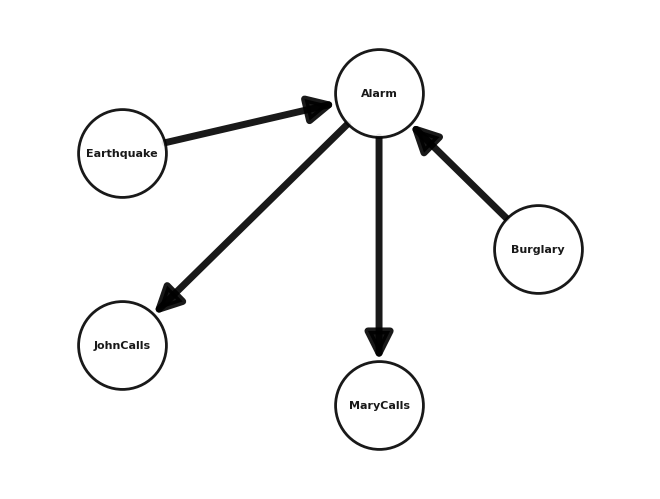

In [3]:
# plot the network

options = {
    "arrowsize": 40,
    "font_size": 8,
    "font_weight": "bold",
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 5,
    "alpha": 0.9,
}

nx.draw_circular(alarm_model, with_labels=True, **options)
# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [4]:
alarm_infer = CausalInference(alarm_model)

# probability John calls given an earthquake.
q = alarm_infer.query(variables=["JohnCalls"], evidence={"Earthquake": True})
print("P(J|E):")
print(q)

# probability that there was an earthquake given John has called.
q = alarm_infer.query(variables=["Earthquake"], evidence={"JohnCalls": True})
print("P(E|J):")
print(q)

# probability of an earthquake given John has not called and Mary has called.
q = alarm_infer.query(
    variables=["Earthquake"], evidence={"JohnCalls": False, "MaryCalls": True}
)
print("P(E|J^c, M):")
print(q)

# probability of a burglary given an alarm and that Mary has not called.
q = alarm_infer.query(
    variables=["Burglary"], evidence={"Alarm": True, "MaryCalls": False}
)
print("P(B|A, M^c):")
print(q)

P(J|E):
+--------------+------------------+
| JohnCalls    |   phi(JohnCalls) |
+==============+==================+
| JohnCalls(0) |           0.7029 |
+--------------+------------------+
| JohnCalls(1) |           0.2971 |
+--------------+------------------+
P(E|J):
+---------------+-------------------+
| Earthquake    |   phi(Earthquake) |
+===============+===================+
| Earthquake(0) |            0.9886 |
+---------------+-------------------+
| Earthquake(1) |            0.0114 |
+---------------+-------------------+
P(E|J^c, M):
+---------------+-------------------+
| Earthquake    |   phi(Earthquake) |
+===============+===================+
| Earthquake(0) |            0.9944 |
+---------------+-------------------+
| Earthquake(1) |            0.0056 |
+---------------+-------------------+
P(B|A, M^c):
+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.6264 |
+-------------+-----------------+
| Bu

In [5]:
%load_ext watermark
%watermark -n -u -v -iv -p pgmpy

Last updated: Sat Mar 18 2023

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.11.0

pgmpy: 0.1.21

networkx  : 3.0
matplotlib: 3.7.0

